# DS SC23x 
## Applied Predictive Modeling

 이번 스프린트 챌린지에서는 시카고에 있는 식당들의 정보와 해당 식당들의 위생 검사 결과에 관한 데이터를 담은 데이터셋을 다루게 됩니다.

데이터셋에 관한 설명은 이 [PDF](https://data.cityofchicago.org/api/assets/BAD5301B-681A-4202-9D25-51B2CAE672FF)를 참고해주시길 바랍니다.

#### 오늘 여러분은 Chicago시의 공중보건부가 진행한 위생 검사의 실패 여부를 예측하는 모델을 만들어야 합니다.

여러분의 모델이 예측할 target은 `Inspection Fail` 칼럼입니다.   
칼럼 값은 아래와 같습니다:
- 식당이 위생 검사에 불합격한 경우: **1**
- 식당이 검사를 통과한 경우: **0**

In [2]:
# Google Colab을 사용하는 경우 해당 셀을 실행하세요
%%capture
import sys

if 'google.colab' in sys.modules:
    # Install packages in Colab
    !pip install category_encoders==2.*
    !pip install eli5
    !pip install pandas-profiling==2.*
    !pip install pdpbox
    !pip install shap

In [3]:
# 데이터셋을 불러오기 위해 판다스 라이브러리를 불러옵니다
import pandas as pd

train_url = 'https://ds-lecture-data.s3.ap-northeast-2.amazonaws.com/food_inspection_sc23x/food_ins_train.csv'
test_url  = 'https://ds-lecture-data.s3.ap-northeast-2.amazonaws.com/food_inspection_sc23x/food_ins_test.csv'

# train, test 데이터셋을 불러옵니다
train = pd.read_csv(train_url)
test  = pd.read_csv(test_url)

# 데이터셋 확인
assert train.shape == (60000, 17)
assert test.shape  == (20000, 17)

# Part 1: 데이터 전처리 (Data Preprocessing)

In [ ]:
## 1.1 데이터셋을 파악하기 위한 EDA를 진행하세요
> EDA를 하는 방식 및 라이브러리에 대한 제한은 없습니다. 단, 시간 분배에 주의하세요.

In [4]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import os 
import seaborn as sns
import folium
from folium import plugins
import datetime
import math

In [ ]:
!pip install geopandas

In [3]:
train.head()

,Inspection ID,DBA Name,AKA Name,License #,Facility Type,Risk,Address,City,State,Zip,Inspection Date,Inspection Type,Violations,Latitude,Longitude,Location,Inspection Fail
0,2050629,MY SWEET STATION INC,MY SWEET STATION,2327223.0,Restaurant,Risk 1 (High),2511 N LINCOLN AVE,CHICAGO,IL,60614.0,2017-05-18,Canvass,NaN,41.927577,-87.651528,"(-87.65152817242594, 41.92757677830966)",0
1,2078428,OUTTAKES,RED MANGO,2125004.0,Restaurant,Risk 2 (Medium),10 S DEARBORN ST FL,CHICAGO,IL,60603.0,2017-08-14,Canvass,"34. FLOORS: CONSTRUCTED PER CODE, CLEANED, GOO...",41.881807,-87.629543,"(-87.62954311539407, 41.88180696006542)",0
2,1591748,JAFFA BAGELS,JAFFA BAGELS,2278918.0,Restaurant,Risk 1 (High),225 N MICHIGAN AVE,CHICAGO,IL,60601.0,2015-12-15,Complaint,"30. FOOD IN ORIGINAL CONTAINER, PROPERLY LABEL...",41.886377,-87.624382,"(-87.62438167043969, 41.88637740620821)",0
3,1230035,FRANKS 'N' DAWGS,FRANKS 'N' DAWGS,2094329.0,Restaurant,Risk 1 (High),1863 N CLYBOURN AVE,CHICAGO,IL,60614.0,2012-07-10,Canvass,33. FOOD AND NON-FOOD CONTACT EQUIPMENT UTENSI...,41.914990,-87.654994,"(-87.65499361162448, 41.91498953039437)",0
4,1228186,SOUTH COAST,SOUTH COAST SUSHI,1817424.0,Restaurant,Risk 1 (High),1700 S MICHIGAN AVE,CHICAGO,IL,60616.0,2013-09-20,Canvass,NaN,41.858996,-87.624106,"(-87.62410566978502, 41.85899630014676)",0


In [4]:
# 결측값 확인
train.isnull().sum()

Inspection ID          0
DBA Name               0
AKA Name             717
License #              4
Facility Type       1427
Risk                  24
Address                0
City                  45
State                 15
Zip                   13
Inspection Date        0
Inspection Type        0
Violations         15870
Latitude             178
Longitude            178
Location             178
Inspection Fail        0
dtype: int64

In [5]:
# 중복값 확인
train.duplicated().sum()

0

In [5]:
# 연/월/일 분리
train['Inspection Date'] = train['Inspection Date'].apply(lambda x: pd.to_datetime(str(x), format='%Y-%m-%d'))

train['year'] = train['Inspection Date'].dt.year
train['month'] = train['Inspection Date'].dt.month
train['day'] = train['Inspection Date'].dt.day

Text(0.5, 0, 'month')

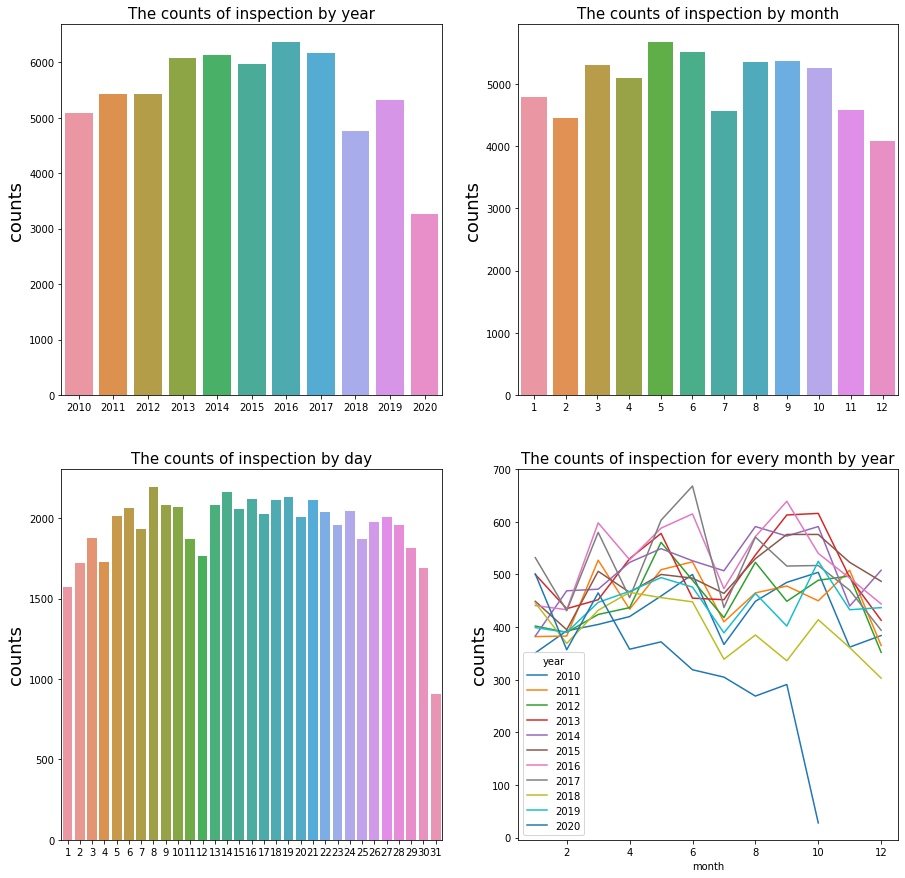

In [48]:
fig,ax=plt.subplots(2,2,figsize=(15,15))

x=train.year.value_counts().index
y=train.year.value_counts()
sns.barplot(x=x,y=y,ax=ax[0,0])
ax[0,0].set_title("The counts of inspection by year",size=15)
ax[0,0].set_ylabel('counts',size=18)
ax[0,0].set_xlabel('')

x=train.month.value_counts().index
y=train.month.value_counts()
sns.barplot(x=x,y=y,ax=ax[0,1])
ax[0,1].set_title("The counts of inspection by month",size=15)
ax[0,1].set_ylabel('counts',size=18)
ax[0,1].set_xlabel('')

x=train.day.value_counts().index
y=train.day.value_counts()
sns.barplot(x=x,y=y,ax=ax[1,0])
ax[1,0].set_title("The counts of inspection by day",size=15)
ax[1,0].set_ylabel('counts',size=18)
ax[1,0].set_xlabel('')

train.groupby(['year','month'])['Inspection ID'].agg('count').unstack('year').plot(ax=ax[1,1])
ax[1,1].set_title("The counts of inspection for every month by year",size=15)
ax[1,1].set_ylabel('counts',size=18)
ax[1,1].set_xlabel('month')

Text(0, 0.5, 'Latitude')

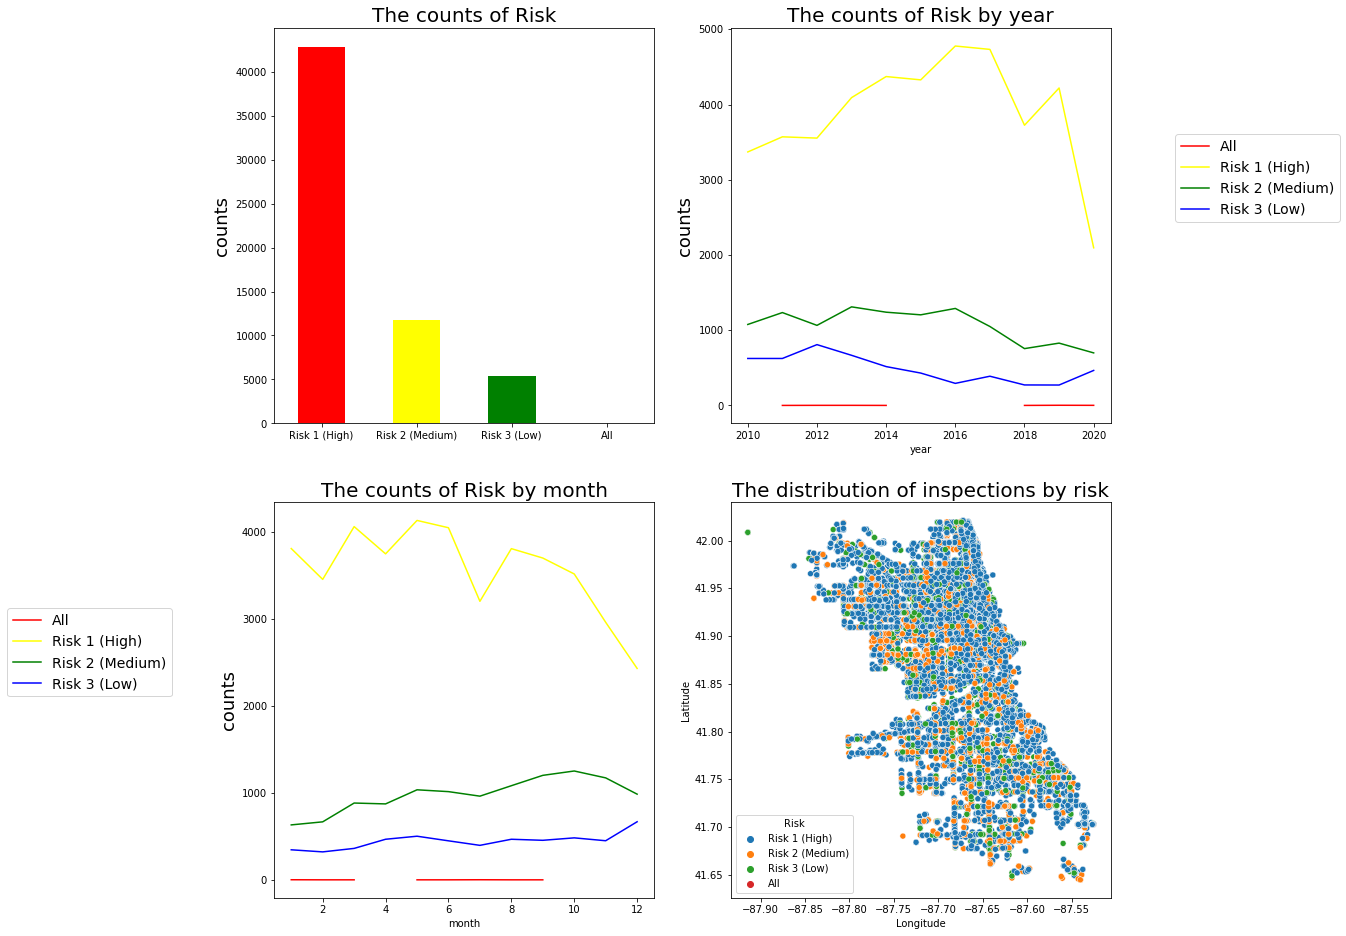

In [55]:
# risk 종류에 따른 분포
fig,ax=plt.subplots(2,2,figsize=(15,16))

train.Risk.value_counts().plot(kind='bar',color=['red','yellow','green','blue'],ax=ax[0,0])
ax[0,0].tick_params(axis='x',labelrotation=360)
ax[0,0].set_title("The counts of Risk",size=20)
ax[0,0].set_ylabel('counts',size=18)


train.groupby(['year','Risk'])['Inspection ID'].agg('count').unstack('Risk').plot(ax=ax[0,1],color=['red','yellow','green','blue'])
ax[0,1].legend(loc=0, ncol=1, fontsize=14,bbox_to_anchor=(1.15,0.75))
ax[0,1].set_title("The counts of Risk by year",size=20)
ax[0,1].set_ylabel('counts',size=18)

train.groupby(['month','Risk'])['Inspection ID'].agg('count').unstack('Risk').plot(ax=ax[1,0],color=['red','yellow','green','blue'])
ax[1,0].legend(loc=0, ncol=1, fontsize=14,bbox_to_anchor=(-0.25,0.75))
ax[1,0].set_title("The counts of Risk by month",size=20)
ax[1,0].set_ylabel('counts',size=18)

sns.scatterplot(x='Longitude', y='Latitude', hue='Risk', data=train, ax=ax[1,1])
ax[1,1].set_title("The distribution of inspections by risk",size=20)
ax[1,1].set_xlabel('Longitude')
ax[1,1].set_ylabel('Latitude')

Text(0.5, 0, 'counts')

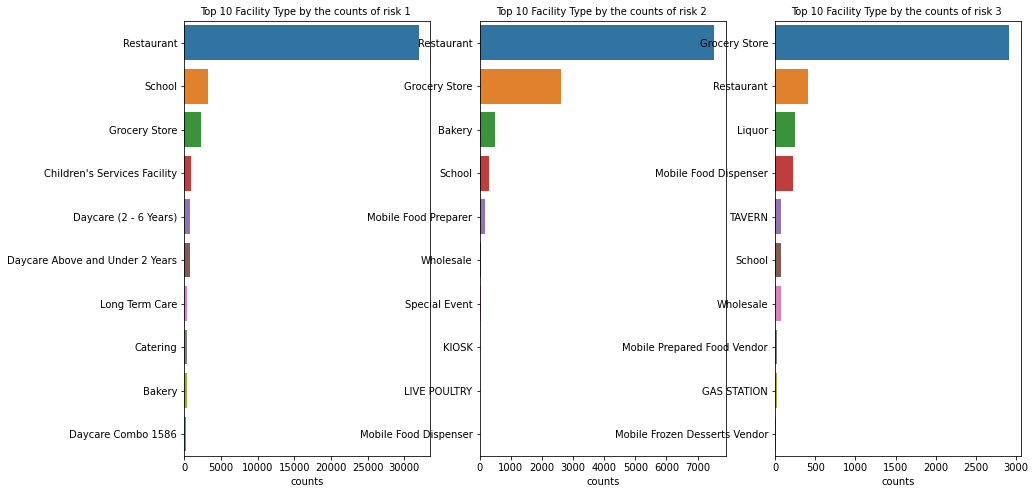

In [62]:
# 각 risk 별 빈도수 확인
data_risk1=train[train.Risk=='Risk 1 (High)']
data_risk2=train[train.Risk=='Risk 2 (Medium)']
data_risk3=train[train.Risk=='Risk 3 (Low)']

fig,ax=plt.subplots(1,3,figsize=(15,8))

sns.barplot(x=data_risk1['Facility Type'].value_counts()[:10],y=data_risk1['Facility Type'].value_counts()[:10].index,ax=ax[0])
ax[0].set_title("Top 10 Facility Type by the counts of risk 1 ",size=10)
ax[0].set_xlabel('counts',size=10)

sns.barplot(x=data_risk2['Facility Type'].value_counts()[:10],y=data_risk2['Facility Type'].value_counts()[:10].index,ax=ax[1])
ax[1].set_title("Top 10 Facility Type by the counts of risk 2 ",size=10)
ax[1].set_xlabel('counts',size=10)

sns.barplot(x=data_risk3['Facility Type'].value_counts()[:10],y=data_risk3['Facility Type'].value_counts()[:10].index,ax=ax[2])
ax[2].set_title("Top 10 Facility Type by the counts of risk 3 ",size=10)
ax[2].set_xlabel('counts',size=10)

0    48284
1    11716
Name: Inspection Fail, dtype: int64


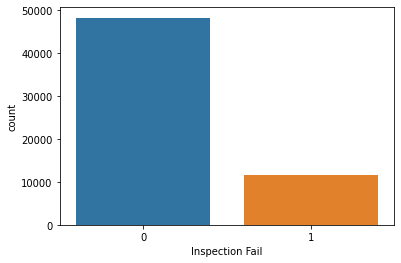

In [66]:
# inspection Fail 빈도 확인
print(pd.Series(train['Inspection Fail']).value_counts())
sns.countplot(x='Inspection Fail', data=train)

In [71]:
pd.Series(train['Violations']).unique()

array([nan,
       '34. FLOORS: CONSTRUCTED PER CODE, CLEANED, GOOD REPAIR, COVING INSTALLED, DUST-LESS CLEANING METHODS USED - Comments: OBSERVED BOXES OF POTATO CHIPS STORED ON THE FLOOR OF DRY STORAGE. INSTRUCTED TO STORE ALL FOOD 6 INCHES ABOVE THE FLOOR TO PROPERLY CLEAN THE FLOOR. | 38. VENTILATION: ROOMS AND EQUIPMENT VENTED AS REQUIRED: PLUMBING: INSTALLED AND MAINTAINED - Comments: OBSERVED THE WASTE PIPE LEAKING AT THE 3 COMPARTMENT SINK MIDDLE BASIN. INSTRUCTED TO REPAIR AND MAINTAIN ALL PLUMBING.  | 42. APPROPRIATE METHOD OF HANDLING OF FOOD (ICE) HAIR RESTRAINTS AND CLEAN APPAREL WORN - Comments: OBSERVED A FOOD HANDLER WITH NO HAIR RESTRAINT. INSTRUCTED TO WEAR A HAIR RESTRAINT WHEN HANDLING FOOD.',
       '30. FOOD IN ORIGINAL CONTAINER, PROPERLY LABELED: CUSTOMER ADVISORY POSTED AS NEEDED - Comments: MUST DATE AND LABEL ALL LARGE PLASTIC TUB CONTAINERS HOLDING CHICKEN IN THE BOTH 2-SLIDING DOOR COOLERS IN THE REAR PART OF THE STORE WHERE THERE ARE 3 SMALL CUSTOMER TABLE

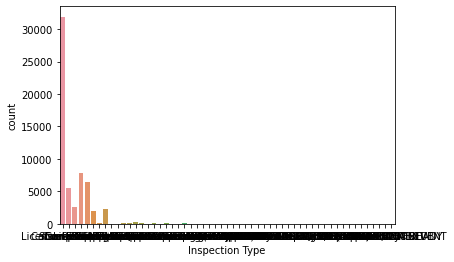

In [76]:
pd.Series(train['Inspection Type']).unique()
sns.countplot(x='Inspection Type', data=train)

## 1.2 EDA의 결과를 토대로 Feature Engineering 및 Preprocessing을 진행하세요
> 새로운 feature를 만드는 작업뿐만이 아니라, 필요한 feature가 적절한 데이터 타입을 가지고 있지 않다면 변환합니다

In [11]:
# facility type에 따라 분류 (restaurant=1, grocery store=2, rest=3)
# violations 유뮤에 따라 분류 (있으면 1, 없으면 0)

def engineer(df):
  df = df.copy()

  # violations 유무에 따라 분류
  df['Violations'].loc[~df['Violations'].isnull()] = 1  # not nan
  df['Violations'].loc[df['Violations'].isnull()] = 0   # nan

  # DBA 모두 대문자로
  # df['DBA Name'].upper()

  return df

# Part 2: 모델링 (Modeling)

## 2.1 검증 방식 (Cross-validation / Hold-out validation)을 정한 후 데이터셋을 목적에 맞게 분할하세요

In [19]:
train.head()

,Inspection ID,DBA Name,AKA Name,License #,Facility Type,Risk,Address,City,State,Zip,Inspection Date,Inspection Type,Violations,Latitude,Longitude,Location,Inspection Fail
47811,1199708,Hops And Barley,Hops And Barley,1444674.0,Restaurant,Risk 1 (High),4359-4361 N MILWAUKEE AVE,CHICAGO,IL,60641.0,2015-01-30,Canvass Re-Inspection,NaN,41.960360,-87.754066,"(-87.75406627395743, 41.96036018734975)",0
32561,577416,RIVER NILE RESTAURNAT,RIVER NILE RESTAURNAT,1277511.0,Restaurant,Risk 1 (High),3259 W 63RD ST,CHICAGO,IL,60629.0,2011-07-01,Complaint,33. FOOD AND NON-FOOD CONTACT EQUIPMENT UTENSI...,41.778828,-87.705434,"(-87.70543426650146, 41.77882757627881)",0
419,614426,PROTEIN BAR,PROTEIN BAR,2079750.0,Restaurant,Risk 1 (High),221 W WASHINGTON ST,CHICAGO,IL,60606.0,2011-08-22,License,2. FACILITIES TO MAINTAIN PROPER TEMPERATURE -...,41.883100,-87.634489,"(-87.63448943715312, 41.883099629998725)",1
57844,1995893,THE GALLERY,THE LIVING ROOM,1937.0,Restaurant,Risk 1 (High),151 E WACKER DR,CHICAGO,IL,60601.0,2017-03-20,Canvass,NaN,41.888000,-87.622565,"(-87.62256513255957, 41.88799988734853)",0
17848,1391483,DRAGON GATE,DRAGON GATE,1595947.0,Restaurant,Risk 1 (High),6528 N CLARK ST,CHICAGO,IL,60626.0,2014-03-21,Canvass,"30. FOOD IN ORIGINAL CONTAINER, PROPERLY LABEL...",42.000733,-87.671666,"(-87.67166628540332, 42.00073293097368)",0


In [7]:
train['Inspection ID'].duplicated().value_counts(normalize=False, sort=True)

False    60000
Name: Inspection ID, dtype: int64

In [13]:
target = 'Inspection Fail'
features = ['Inspection ID', 'DBA Name', 'Facility Type',	'Risk', 'Inspection Date', 'Inspection Type',	'Violations']

# 훈련/검증 데이터 나누기
from sklearn.model_selection import train_test_split
train, val = train_test_split(train, train_size=0.80, test_size=0.20, 
                              stratify=train[target], random_state=2)

train = engineer(train)
val = engineer(val)
test = engineer(test)

# 타겟과 특성을 분리
features = train.drop(columns=[target]).columns

# 훈련/검증/테스트 데이터를 특성과 타겟으로 분리
X_train = train[features]
y_train = train[target]
X_val = val[features]
y_val = val[target]
X_test = test[features]

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


KeyError: ignored

In [17]:
X_train.head()

,Inspection ID,DBA Name,Facility Type,Risk,Inspection Date,Inspection Type,Violations
47811,1199708,Hops And Barley,Restaurant,Risk 1 (High),2015-01-30,Canvass Re-Inspection,0
32561,577416,RIVER NILE RESTAURNAT,Restaurant,Risk 1 (High),2011-07-01,Complaint,1
419,614426,PROTEIN BAR,Restaurant,Risk 1 (High),2011-08-22,License,1
57844,1995893,THE GALLERY,Restaurant,Risk 1 (High),2017-03-20,Canvass,0
17848,1391483,DRAGON GATE,Restaurant,Risk 1 (High),2014-03-21,Canvass,1


## 2.2 모델 학습을 위한 파이프라인을 구축 후 학습(fit)까지 진행하세요
> 모델은 scikit-learn, xgboost 등 어떤 라이브러리를 사용하셔도 괜찮지만 특정 라이브러리는 설치 및 설정에 시간이 소요되는 점을 감안하시기 바랍니다

In [1]:
from sklearn.pipeline import make_pipeline
from category_encoders import OrdinalEncoder
from sklearn.impute import SimpleImputer

# encoding, imputing
pre_process = make_pipeline(
    OrdinalEncoder(),
    SimpleImputer()
)

ModuleNotFoundError: ignored

In [15]:
!pip install sklearn

In [16]:
X_train_pred = pre_process.fit_transform(X_train)
X_val_pred = pre_process.transform(X_val)

/usr/local/lib/python3.7/dist-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


TypeError: ignored

In [11]:
X_train_pred = pre_process.fit_transform(X_train)
X_val_pred = pre_process.transform(X_val)

# model
from xgboost import XGBClassifier
xgb_cf = XGBClassifier(
    n_estimators=1000,
    verbosity=0,
    max_depth=7,
    learning_rate=0.2,
    n_jobs=-1,
    random_state=2
)

# fit
xgb_cf.fit(X_train_pred, y_train,
           eval_set=eval_set,
           eval_metric='auc')

TypeError: ignored

## 2.3 테스트셋의 ROC / AUC 검증 점수를 예측합니다
> 제작한 모델을 활용해서 테스트셋의 **확률**을 예측하세요 (`ROC/AUC 검증 점수`를 **0.65 혹은 그 이상** 달성한다면 매우 훌륭한 모델입니다)

In [ ]:
# 이 곳에 답안을 작성해주시길 바랍니다

## 2.4 하이퍼 파라미터 튜닝을 통해서 모델을 개선하세요
> `RandomSearchCV`, `GridSearchCV` 등을 활용해서 모델의 성능을 개선합니다. 범위 설정에 따라 시간이 매우 소요될 수 있습니다.

In [12]:
## 하이퍼파라미터 최적값 찾기 ##
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint, uniform
from sklearn.ensemble import RandomForestClassifier

# RandomizedSearchCV 
pipe = make_pipeline(
    OrdinalEncoder(), 
    SimpleImputer(), 
    RandomForestClassifier(random_state=1)
)

dists = {   
    'simpleimputer__strategy': ['mean', 'median'], 
    'randomforestclassifier__class_weight' : ['balanced', None],
    'randomforestclassifier__n_estimators' : randint(50, 500), 
    'randomforestclassifier__max_depth': [5, 10], 
    'randomforestclassifier__max_features': uniform(0, 1), 
    'randomforestclassifier__min_samples_leaf' : randint(1,5)
}
clf = RandomizedSearchCV(
    pipe, 
    param_distributions=dists, 
    n_iter=50, 
    cv=3, 
    scoring='f1',  
    verbose=1,
    n_jobs=-1
)

clf.fit(X_train, y_train);

print('최적 하이퍼파라미터: ', clf.best_params_)
print('f1: ', clf.best_score_)

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


Fitting 3 folds for each of 50 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:    5.3s
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:   13.9s finished


TypeError: ignored

In [ ]:
# 이 곳에 답안을 작성해주시길 바랍니다

## Part 3: 시각화 (Visualization)

> 모델의 해석을 위한 시각화를 해주세요. 아래의 제시 된 종류 중 2가지를 선택하세요 (시각화에 가장 중요한 것은 **여러분의 분석**입니다.):
> - Permutation Importances
> - Partial Dependence Plot, 1 feature isolation
> - Partial Dependence Plot, 2 features interaction
> - Shapley Values

In [ ]:
# 이 곳에 답안을 작성해주시길 바랍니다